In [195]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader




# Add custom module path
module_path = os.path.abspath(os.path.join('scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from helper_functions import extract_spectrograms

# IRIS client instance
client = Client('IRIS')

from typing import Any

from scipy.signal import correlate




In [196]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_3776147/2645211226.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', 

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [197]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:56.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:51.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:07:29.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:29:40.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:11:46.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:11:49.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:48:28.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [198]:
event = exotic.iloc[3]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3177488
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SUG
station_location_code                              --
station_latitude_deg                           46.215
station_longitude_deg                        -122.176
station_elevation_m                            1864.0
trace_name                        bucket1$5,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-12-06T23:48:51.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                       5.281|8.824|18.920
Name: 360, dtype: object


## Local version

In [216]:
# defining the constants
# amount of tapering
taper_alpha = 0.1
# filter parameters
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
lowcut = 1
highcut = 20
fs = 50
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients





## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)




orig_s = np.array(s)



# detrending
s.detrend(type = 'linear')


# resampling
s.resample(50)



# this contains detrended data
detrended_data_local = np.array(s)



# event data
event_data = np.array(s)

# tapering before filtering
taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
tapered_data = np.array([np.multiply(taper, row) for row in event_data])


#Apply bandpass filtering
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





# resampling and normalizing 
num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

resampled_data = resampled_data[:,0:5000]
resampled_data = resampled_data.reshape(1,3, 5000)

mmax = np.std(np.abs(resampled_data[0]))
norm = resampled_data/mmax



In [217]:
lowcut = 1
highcut = 20
fs = 50


def linear_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Apply linear detrending similar to ObsPy.
    """
    # Time indices
    time = torch.arange(tensor.shape[-1], dtype=tensor.dtype, device=tensor.device)

    # Calculate linear fit coefficients using least squares
    time_mean = time.mean()
    time_variance = ((time - time_mean) ** 2).sum()
    slope = ((tensor * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_variance
    intercept = tensor.mean(dim=-1, keepdim=True) - slope * time_mean

    # Compute the trend
    trend = slope * time + intercept

    # Remove the trend from the original tensor
    return tensor - trend



def exact_scipy_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Exact PyTorch equivalent of scipy.signal.detrend(type='linear').

    tensor shape: (C, T) or (B, C, T)
    """
    orig_shape = tensor.shape
    if tensor.ndim == 1:
        tensor = tensor.unsqueeze(0)  # (1, T)
    elif tensor.ndim == 3:
        tensor = tensor.view(-1, tensor.shape[-1])  # (B*C, T)
    
    N, T = tensor.shape
    t = torch.arange(T, dtype=tensor.dtype, device=tensor.device).unsqueeze(0).expand(N, -1)  # (N, T)

    ones = torch.ones_like(t)
    A = torch.stack([t, ones], dim=1).transpose(1, 2)  # shape: (N, T, 2)

    # Least squares: (A^T A)^-1 A^T y
    A_T = A.transpose(1, 2)  # (N, 2, T)
    coeffs = torch.linalg.lstsq(A, tensor.unsqueeze(-1)).solution.squeeze(-1)  # (N, 2)

    slope = coeffs[:, 0].unsqueeze(1)  # (N, 1)
    intercept = coeffs[:, 1].unsqueeze(1)  # (N, 1)

    trend = slope * t + intercept  # (N, T)
    detrended = tensor - trend

    return detrended.view(orig_shape)




# Apply the filter using filtfilt
def bandpass_filter(batch: torch.Tensor, fs: float, lowcut: float, highcut: float, order = 4) -> torch.Tensor:
    # Convert tensor to numpy array
    input_numpy = batch.numpy()  # Shape: (batch_size, num_channels, window_length)

    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b,a  = butter(order, [low, high], btype = 'band')

    # Apply the bandpass filter to each batch and each channel
    filtered_numpy = np.zeros_like(input_numpy)
    for i in range(input_numpy.shape[0]):  # Iterate over batch size
        for j in range(input_numpy.shape[1]):  # Iterate over channels
            filtered_numpy[i, j, :] = filtfilt(b, a, input_numpy[i, j, :])

    # Convert back to tensor
    filtered_tensor = torch.tensor(filtered_numpy)
    return filtered_tensor



def normalize_per_trace_globally(batch: torch.Tensor) -> torch.Tensor:
    """
    Normalize each trace (across all 3 components) using a single std,
    exactly like the NumPy version that does:
    norm = resampled_data / np.std(np.abs(resampled_data[0]))
    
    Input shape:  (B, 3, T)
    Output shape: (B, 3, T)
    """
    batch_abs = torch.abs(batch)                     # (B, 3, T)
    stds = batch_abs.view(batch.shape[0], -1).std(dim=1, keepdim=True)  # (B, 1)
    stds = stds.view(-1, 1, 1)                        # reshape to broadcast (B, 1, 1)
    return batch / (stds + 1e-10)



In [218]:
## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)






# resample to 50 Hz
s.resample(50)



# converting into array
event_data = np.array(s)[:, :5000]

# reshaping for shape compatibility
event_data = event_data.reshape(1, 3, 5000)

# converting into pytorch tensor. 
batch = torch.tensor(event_data, dtype=torch.float32)



# detrending
detrended_batch = linear_detrend(batch)



# tapering
device = 'cpu'
tukey_window = scipy.signal.windows.tukey(detrended_batch.shape[-1], alpha=0.1)

# Convert the Tukey window to a PyTorch tensor
taper = torch.tensor(tukey_window, device=batch.device)
        
# Apply the Tukey window to the batch
tapered_batch = detrended_batch * taper  # Broadcasting over last axis
    


    
# filtering 
filtered_batch = bandpass_filter(tapered_batch, fs, lowcut, highcut)



norm_batch = normalize_per_trace_globally(filtered_batch)

"""
# Normalize each component by the standard deviation of their absolute values
batch_abs = torch.abs(filtered_batch)
std_abs = batch_abs.std(dim=-1, keepdim=True)
norm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero
"""

'\n# Normalize each component by the standard deviation of their absolute values\nbatch_abs = torch.abs(filtered_batch)\nstd_abs = batch_abs.std(dim=-1, keepdim=True)\nnorm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero\n'

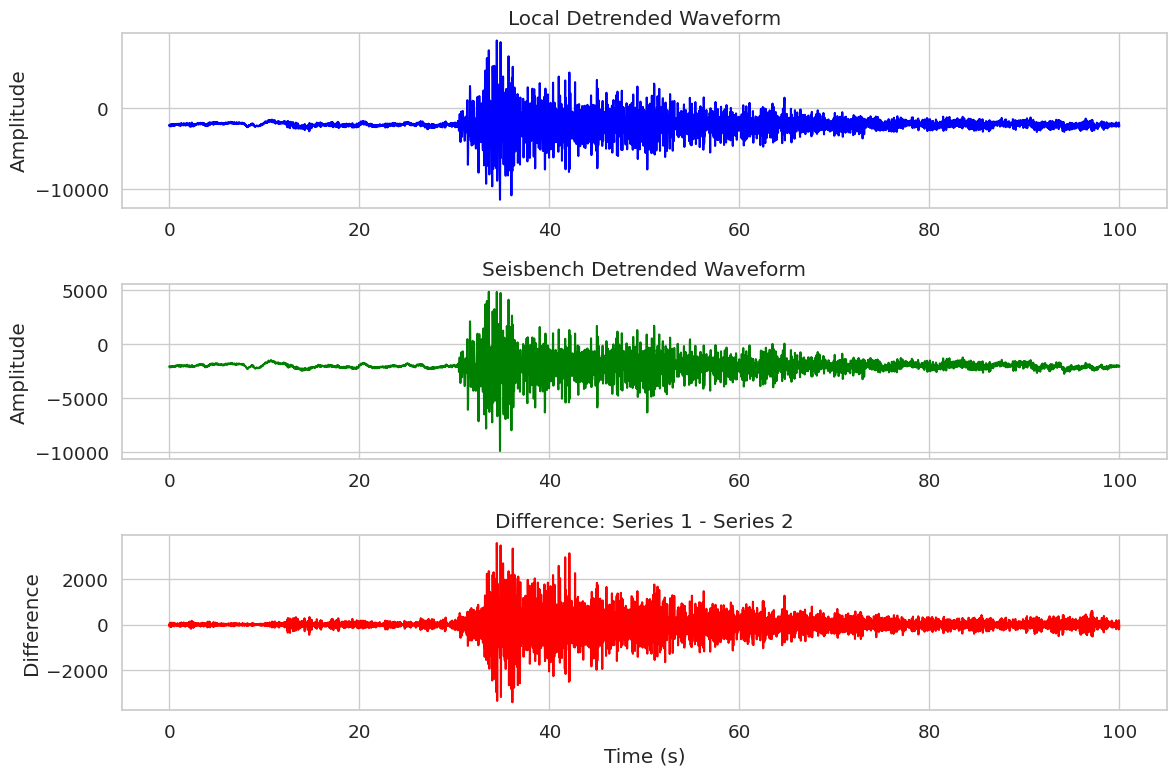

In [219]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = orig_s[2][0:5000]
series2 = batch[0][2].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
#plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


In [208]:
s

3 Trace(s) in Stream:
CC.SUG..BHE | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples
CC.SUG..BHN | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples
CC.SUG..BHZ | 2021-12-06T23:48:41.000000Z - 2021-12-06T23:50:21.000000Z | 50.0 Hz, 5001 samples

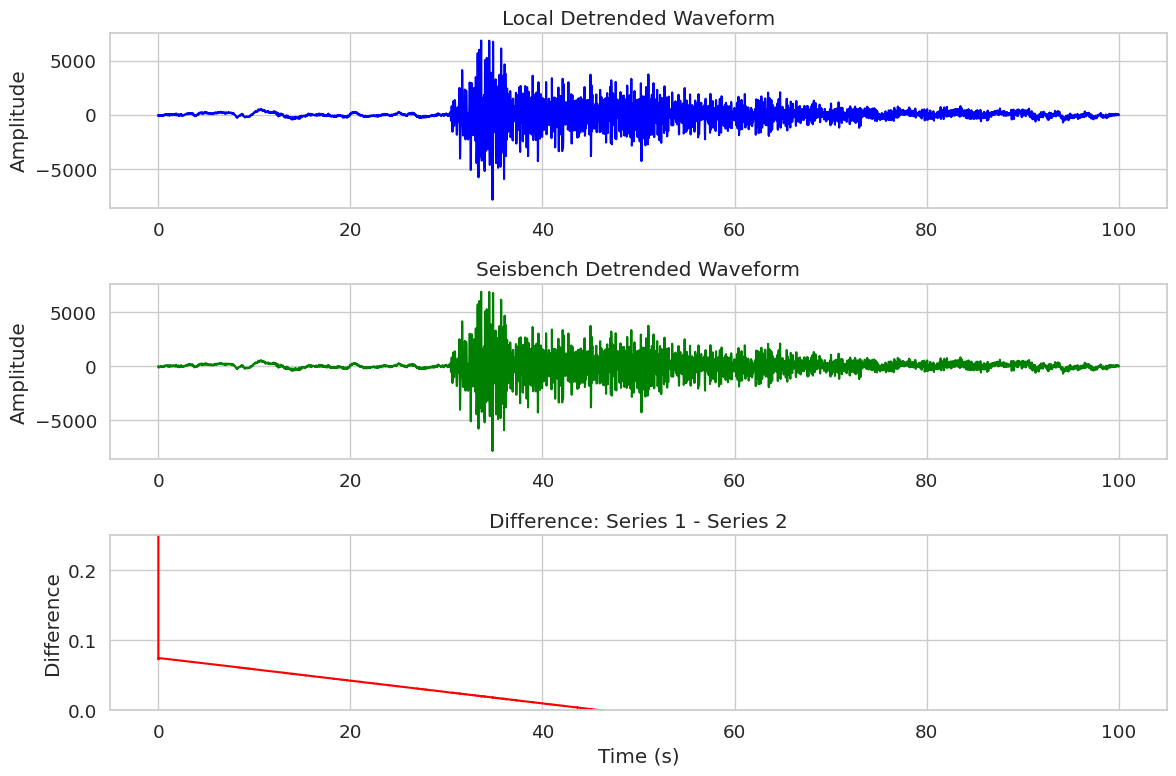

In [207]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = detrended_data_local[2][0:5000]
series2 = detrended_batch[0][2].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


In [204]:
series1

array([ -36.80237825, -131.7850106 ,  -98.48177889, ...,   64.04706947,
         19.75242967,  -50.30519865])

In [205]:
series2

array([ -41.811768, -131.85779 ,  -98.555786, ...,   64.13403 ,
         19.839355,  -50.219604], dtype=float32)

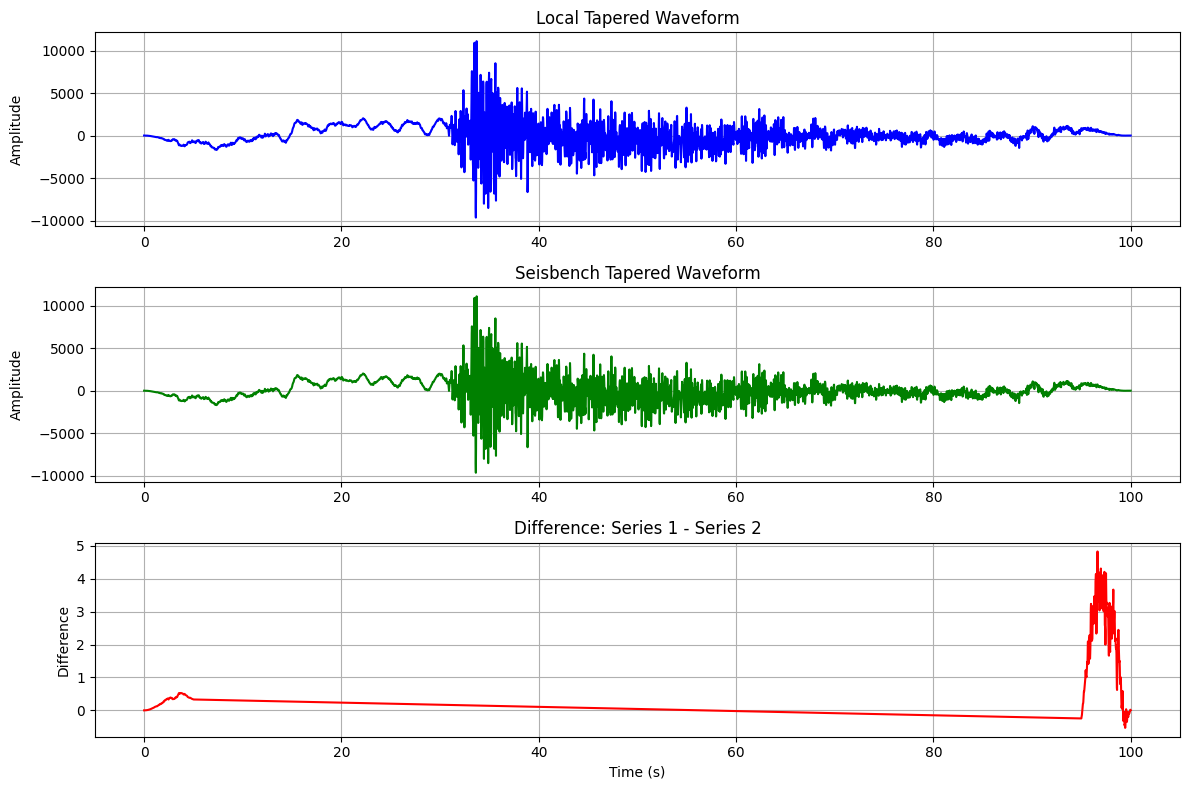

In [141]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = tapered_data[0][:5000]
series2 = tapered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


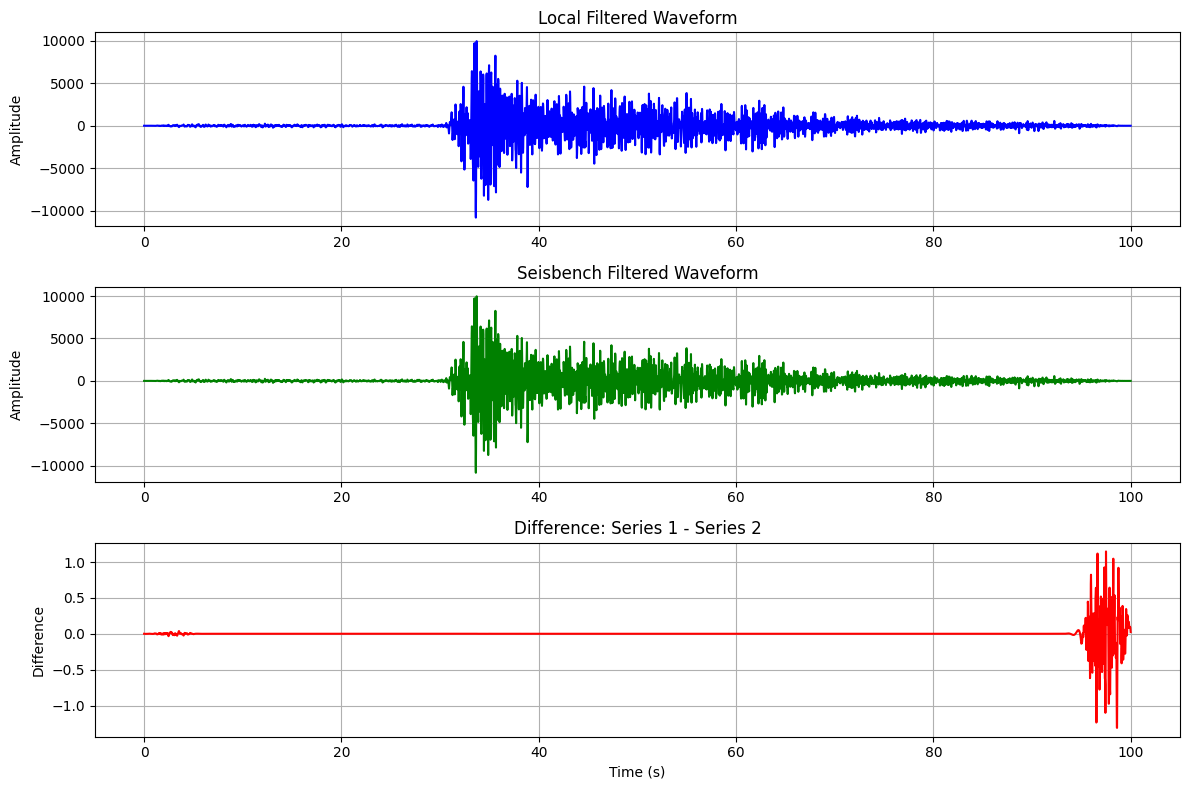

In [142]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = resampled_data[0][0][:5000]
series2 = filtered_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


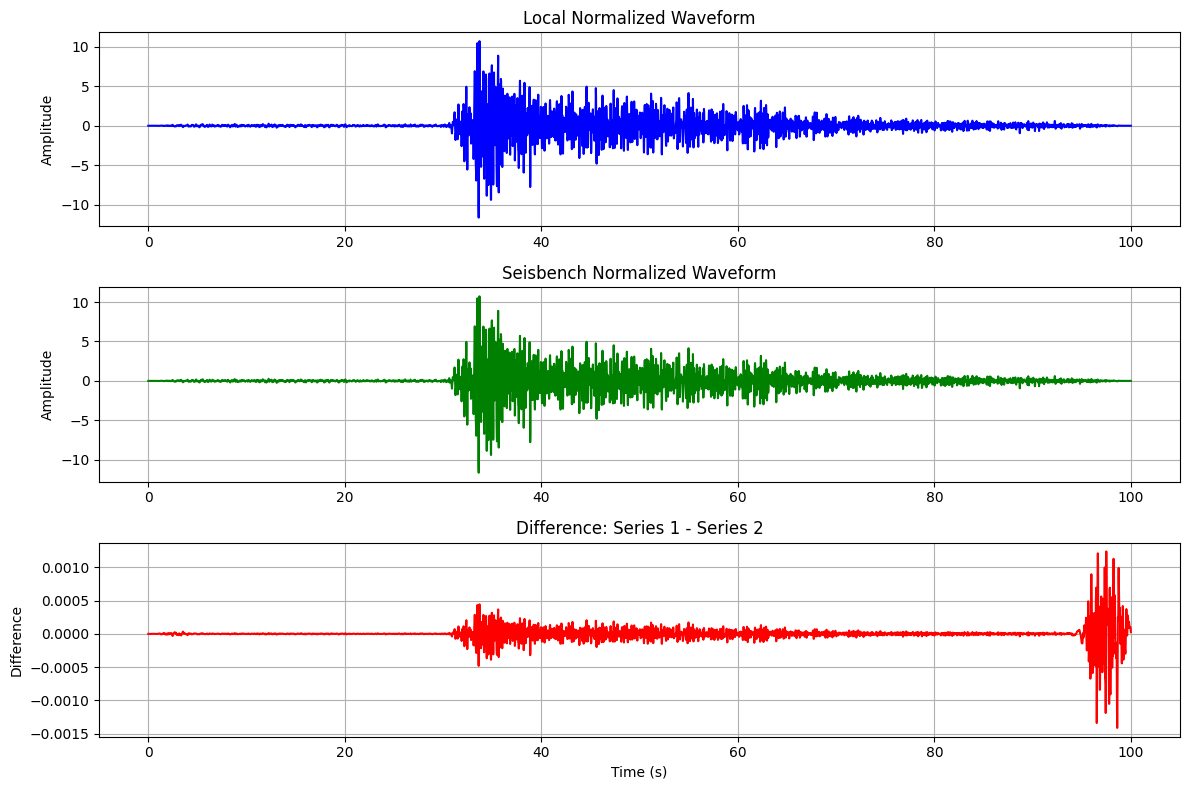

In [143]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = norm[0][0][:5000]
series2 = norm_batch[0][0].numpy()

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)

plt.tight_layout()
plt.show()


In [144]:
from helper_functions import extract_spectrograms
help(extract_spectrograms)

Help on function extract_spectrograms in module helper_functions:

extract_spectrograms(waveforms=[], fs=50, nperseg=256, overlap=0.5, print_shape=False)



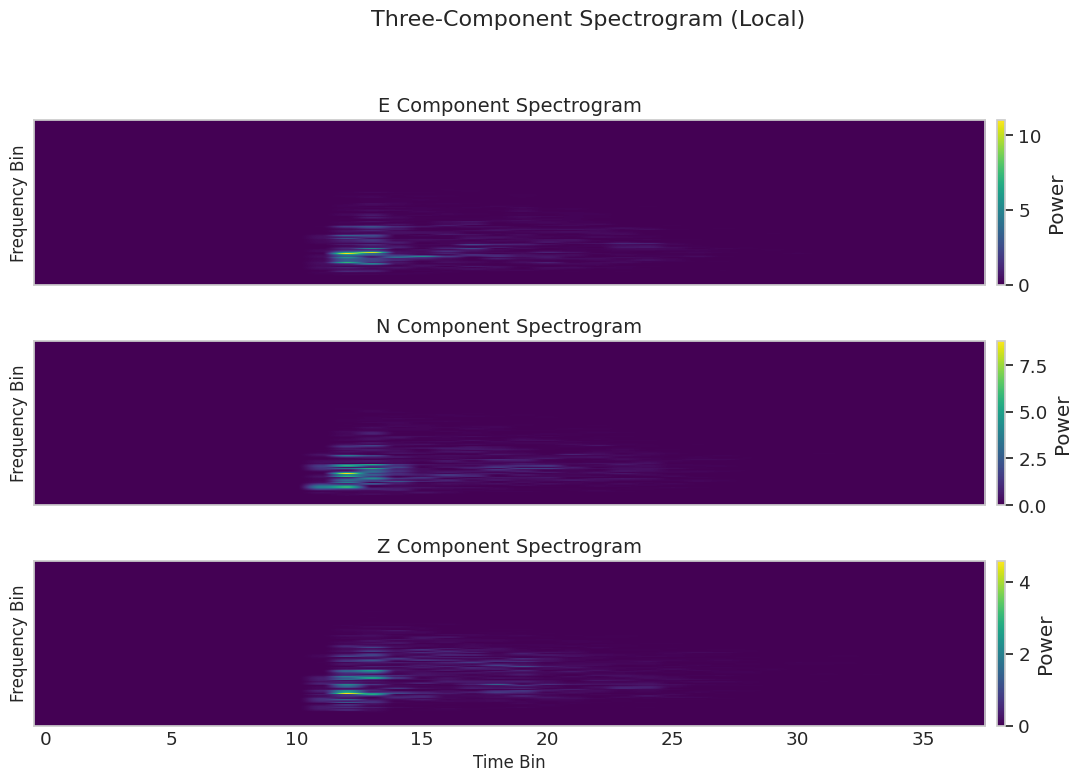

In [336]:
nperseg=256
overlap=0.5
fs = 50
noverlap = int(nperseg * overlap)  # Calculate overlap
f, t, _ = signal.spectrogram(norm, nperseg=nperseg, noverlap=noverlap, fs=fs)

spec_local = extract_spectrograms(norm)


# Assume `spectrogram` has shape (1, 3, 129, 38)
# spectrogram = your_spectrogram_array
# f, t = frequencies and times from signal.spectrogram

components = ['Z', 'N', 'E']
spec = spec_local[0]  # Remove batch dimension, now shape (3, 129, 38)

# Assume `spectrogram` is a torch.Tensor of shape (1, 3, 129, 38)
spec = spec_local[0] # shape: (3, 129, 38)



components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spec[i],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Local)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [349]:
def extract_spectrograms(waveforms = a, fs = fs, nperseg=256, overlap=0.5, print_shape = False):
    noverlap = int(nperseg * overlap)  # Calculate overlap

    # Example of how to get the shape of one spectrogram
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)

    # Initialize an array of zeros with the shape: (number of waveforms, channels, frequencies, time_segments)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs)
            spectrograms[i, j] = Sxx  # Fill the pre-initialized array

    if print_shape:
        print(spectrograms.shape)
    return spectrograms





def extract_spectrograms_pytorch(waveforms, fs, nperseg=256, overlap=0.5):
    """
    Extract spectrograms, time segments, and frequency bins from waveforms.

    Parameters:
        waveforms: Tensor of shape (n_waveforms, n_channels, n_samples)
        fs: Sampling rate (Hz)
        nperseg: Number of FFT points
        overlap: Fractional overlap between segments

    Returns:
        spectrograms: Tensor of shape (n_waveforms, n_channels, frequencies, time_segments)
        frequencies: Array of frequency bins (Hz)
        time_segments: Array of time segment centers (seconds)
    """
    noverlap = int(nperseg * overlap)  # Calculate overlap
    hop_length = nperseg - noverlap  # Calculate hop length

    # Compute frequencies
    frequencies = torch.fft.rfftfreq(nperseg, d=1/fs)

    # Compute time segments
    time_segments = torch.arange(0, waveforms.shape[-1] - nperseg + 1, hop_length) / fs
    
    window = torch.hann_window(nperseg, device=waveforms.device)


    # Example spectrogram to get dimensions
    example_spectrogram = torch.stft(
        waveforms[0, 0], n_fft=nperseg, window = window, hop_length=hop_length, win_length=nperseg, 
        return_complex=True, center=False, normalized = False
    )
    freq_bins, time_bins = example_spectrogram.shape[-2], example_spectrogram.shape[-1]

    # Initialize tensor for spectrograms
    spectrograms = torch.zeros(
        (waveforms.shape[0], waveforms.shape[1], freq_bins, time_bins), dtype=torch.complex64
    )

    # Compute spectrograms
    for i in range(waveforms.shape[0]):  # For each waveform
        for j in range(waveforms.shape[1]):  # For each channel
            Sxx = torch.stft(
                waveforms[i, j], n_fft=nperseg, hop_length=hop_length, win_length=nperseg, window = window,  
                return_complex=True, center=False, normalized= False,
            )
            spectrograms[i, j] = Sxx  # Fill the tensor

    # Convert complex spectrogram to magnitude
    spectrograms = torch.abs(spectrograms)**(2)

    return spectrograms, frequencies, time_segments




def extract_spectrograms_torch_matched(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, device=waveforms.device)
    frequencies = torch.fft.rfftfreq(nperseg, d=1/fs)
    time_segments = torch.arange(0, waveforms.shape[-1] - nperseg + 1, hop_length) / fs

    # Example to get shape
    example_spec = torch.stft(
        waveforms[0, 0], n_fft=nperseg, hop_length=hop_length, win_length=nperseg,
        return_complex=True, window=window, center=False, normalized= True
    )
    freq_bins, time_bins = example_spec.shape[-2], example_spec.shape[-1]

    spectrograms = torch.zeros(
        (waveforms.shape[0], waveforms.shape[1], freq_bins, time_bins),
        dtype=torch.complex64, device=waveforms.device
    )

    for i in range(waveforms.shape[0]):
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j], n_fft=nperseg, hop_length=hop_length, win_length=nperseg,
                return_complex=True, window=window, center=False, normalized= True
            )
            spectrograms[i, j] = Sxx

    power = torch.abs(spectrograms)**2
    return power, frequencies, time_segments



def extract_spectrograms_torch_matched_new(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, dtype=waveforms.dtype, device=waveforms.device)
    window_energy = window.pow(1).sum()

    spec = []
    for i in range(waveforms.shape[0]):
        comps = []
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j],
                n_fft=nperseg,
                hop_length=hop_length,
                win_length=nperseg,
                window=window,
                center=False,
                return_complex=True,
                normalized= False,  # better match
            )
            power = torch.abs(Sxx)**2/window_energy  # 🔥 critical step
            comps.append(power)
        spec.append(torch.stack(comps))

    return torch.stack(spec)  # shape: (B, 3, F, T)




def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Replicates scipy.signal.spectrogram with defaults:
    window='hann', detrend='constant', scaling='density', mode='psd'.

    Parameters
    ----------
    x : Tensor, shape (B, C, N)        ➊ batch, channels, samples
    fs : float                         ➋ sampling rate [Hz]

    Returns
    -------
    psd : Tensor, shape (B, C, F, T)   power-spectral-density [units²/Hz]
    freqs : 1-D Tensor, length F
    times : 1-D Tensor, length T
    """
    B, C, N = x.shape
    nperseg = int(nperseg)
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap

    # ----- ① Hann window (periodic, like SciPy) -----------------------------
    window = torch.from_numpy(signal.windows.hann(256, sym=True)).to(device)

    #window = torch.hann_window(nperseg, periodic=True,
                               dtype=x.dtype, device=x.device)

    # Pre–compute scale factor ③
    W = window.pow(2).sum()            # Σ w²
    scale = 1.0 / (W * fs)             # for 'density'

    # ➌ STFT wants (B*C, N) 2-D input
    x2 = x.reshape(B * C, N)

    # ----- ② detrend='constant': subtract frame-means -----
    ones_win = torch.ones(1, 1, nperseg, dtype=x.dtype, device=x.device) / nperseg
    pad      = nperseg // 2                             # 128 for k=256
    mu = F.conv1d(x2.unsqueeze(1), ones_win, stride=1, padding=pad).squeeze(1)

    # conv1d adds one extra sample when kernel is even; crop it off
    if mu.shape[-1] > x2.shape[-1]:
        mu = mu[..., : x2.shape[-1]]

    x2 = x2 - mu

    # ----- ④ STFT -----------------------------------------------------------
    """
    Z = torch.stft(x2,
        n_fft=nperseg,
        hop_length=hop,
        win_length=nperseg,
        window=window,
        center=False,                   # boundary=None
        return_complex=True,
        normalized=False,               # matches SciPy
    )  # → (B*C, F, T)
    
    """

    # reshape back
    Z = Z.view(B, C, *Z.shape[-2:])     # (B, C, F, T)

    # ----- ③ scale to PSD / Hz &  ×2 for one-sided --------------------------
    psd = (Z.abs() ** 2) * scale
    if nperseg % 2 == 0:                # even n_fft has Nyquist bin
        psd[..., 1:-1, :] *= 2.0        # skip DC & Nyquist
    else:
        psd[..., 1:, :]   *= 2.0        # skip DC only

    # frequency & time axes (to mimic SciPy outputs)
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(0, N - nperseg + 1, hop, dtype=x.dtype, device=x.device) / fs

    return psd, freqs, times




def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    B, C, N = x.shape
    hop = nperseg - int(nperseg * overlap)

    window = torch.hann_window(nperseg, periodic=True,
                               dtype=x.dtype, device=x.device)

    # --- STFT ---------------------------------------------------------------
    Z = torch.stft(
        x.reshape(B * C, N),
        n_fft=nperseg,
        hop_length=hop,
        win_length=nperseg,
        window=window,
        center=False,             # boundary=None
        normalized=False,
        return_complex=True,
    ).view(B, C, 129,38)          # (B, C, F, T)

    # --- PSD scaling --------------------------------------------------------
    W = window.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2
    else:
        psd[..., 1:, :]   *= 2

    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(0, N - nperseg + 1, hop,
                         dtype=x.dtype, device=x.device) / fs
    return psd, freqs, times




def spectrogram_torch_exact(x, fs, nperseg=256, overlap=0.5):
    """
    Replica of scipy.signal.spectrogram with:
        window='hann', sym=False
        detrend=False
        scaling='density'
        mode='psd'
        boundary=None        (i.e. no padding)
    Parameters
    ----------
    x : Tensor (B, C, N)   batch, channels, samples
    fs : float             sampling rate [Hz]
    Returns
    -------
    psd : Tensor (B, C, F, T)   PSD [units² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    nperseg = int(nperseg)
    hop     = nperseg - int(nperseg * overlap)

    # 1. Hann window identical to SciPy's default  (sym=False ⇔ periodic=True)
    window = torch.hann_window(nperseg, periodic=True,
                               dtype=x.dtype, device=x.device)

    # 2. STFT (no padding, no √N normalisation)
    Z = torch.stft(
        x.reshape(B * C, N),
        n_fft         = nperseg,
        hop_length    = hop,
        win_length    = nperseg,
        window        = window,
        center        = False,          # boundary=None
        normalized    = False,
        return_complex=True,
    )                                   # (B*C, F, T)

    F, T = Z.shape[-2:]
    Z = Z.view(B, C, F, T)              # (B, C, F, T)

    # 3. PSD scaling  |Z|² / (fs Σ w²)
    W   = window.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)

    # 4. One-sided ×2  (skip DC and Nyquist)
    if nperseg % 2 == 0:                # even n_fft → Nyquist present
        psd[..., 1:-1, :] *= 2.0
    else:                               # odd n_fft
        psd[..., 1:, :]   *= 2.0

    # 5. frequency & time axes (to match SciPy outputs)
    freqs = torch.fft.rfftfreq(nperseg, 1/fs).to(x.device)
    times = torch.arange(0, N - nperseg + 1, hop,
                         dtype=x.dtype, device=x.device) / fs
    return psd, freqs, times




def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Identical to scipy.signal.spectrogram with *default* kwargs:
        window='hann',      sym=True
        detrend='constant', scaling='density', mode='psd'
        boundary=None       (SciPy ≥1.10)
    Input
    -----
    x  : Tensor (B, C, N)     batch × channels × samples
    fs : float                sampling rate [Hz]
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F   frequency bins (Hz)
    times : 1-D Tensor length T   centre of each segment (s)
    """
    B, C, N = x.shape
    nperseg = int(nperseg)
    hop     = nperseg - int(nperseg * overlap)

    # ① symmetric Hann (periodic=False)  → SciPy default
    win = torch.hann_window(nperseg, periodic=False,
                            dtype=x.dtype, device=x.device)

    # ② frame the signal: shape (B, C, T, nperseg)
    segs = x.unfold(-1, nperseg, hop)                    # (B,C,T,L)
    # SciPy uses floor division ⇒ exactly this many frames
    T = segs.shape[-2]

    # ③ detrend='constant'  (subtract mean of each segment *before* window)
    segs = segs - segs.mean(dim=-1, keepdim=True)

    # ④ apply window
    segs = segs * win                                  # broadcasts

    # ⑤ rFFT along the last axis → (B,C,T,F)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1)

    # ⑥ move F before T to match SciPy layout  (B,C,F,T)
    Z = Z.permute(0, 1, 3, 2).contiguous()

    # ⑦ PSD scaling  |Z|² / (fs Σw²)
    W   = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)

    # ⑧ one-sided ×2  (skip DC and Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :]   *= 2.0

    # ⑨ frequency & time vectors
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(T, dtype=x.dtype, device=x.device) * hop / fs

    return psd, freqs, times          # shape (B, C, F=129, T=38)



def torch_spectrogram_matches_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Perfect replica of scipy.signal.spectrogram (defaults).
    x shape: (B, C, N)  float64 recommended.
    returns PSD (B,C,F,T)   freqs, times
    """
    B, C, N = x.shape
    hop     = nperseg - int(nperseg * overlap)

    # 🔥 SciPy default window is *symmetric* Hann, not periodic
    win = torch.hann_window(nperseg, periodic=False,
                            dtype=x.dtype, device=x.device)

    # frame, subtract mean of each frame BEFORE window  (detrend='constant')
    segs = x.unfold(-1, nperseg, hop)            # (B,C,T,L)
    segs = segs - segs.mean(-1, keepdim=True)    # detrend
    segs = segs * win                            # apply window

    Z = torch.fft.rfft(segs, n=nperseg, dim=-1)  # (B,C,T,F)
    Z = Z.permute(0,1,3,2)                       # (B,C,F,T)

    # PSD: |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs()**2) / (W * fs)

    # 🔥 One-sided ×2   (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[...,1:-1,:] *= 2
    else:
        psd[...,1:,:]   *= 2

    freqs = torch.fft.rfftfreq(nperseg, 1/fs).to(x.device)
    times = torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop / fs
    return psd, freqs, times



import torch


def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of `scipy.signal.spectrogram` with *all defaults*:
        window='hann'  (symmetric)
        detrend='constant'   <-- mean removed **after** window
        scaling='density', mode='psd'
        boundary=None
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    hop     = nperseg - int(nperseg * overlap)

    # 1 ▸ symmetric Hann (SciPy default)
    win = torch.hann_window(nperseg, periodic=False,
                            dtype=x.dtype, device=x.device)

    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)

    # 3 ▸ apply window *first*
    segs = segs * win

    # 4 ▸ detrend='constant'  (subtract mean of each *windowed* segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)

    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)

    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W   = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)

    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :]   *= 2.0

    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(psd.shape[-1],
                         dtype=x.dtype, device=x.device) * hop / fs
    return psd, freqs, times


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 229)

In [381]:
def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of `scipy.signal.spectrogram` with *all defaults*:
        window='hann'  (symmetric)
        detrend='constant'   <-- mean removed **after** window
        scaling='density', mode='psd'
        boundary=None
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    hop     = nperseg - int(nperseg * overlap)

    # 1 ▸ symmetric Hann (SciPy default)
    win = torch.hann_window(nperseg, periodic=False,
                            dtype=x.dtype, device=x.device)

    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)

    # 3 ▸ apply window *first*
    segs = segs * win

    # 4 ▸ detrend='constant'  (subtract mean of each *windowed* segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)

    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)

    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W   = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)

    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :]   *= 2.0

    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(psd.shape[-1],
                         dtype=x.dtype, device=x.device) * hop / fs
    return psd, freqs, times



def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    win = torch.hann_window(nperseg, periodic=True,
                            dtype=x.dtype, device=x.device)
    
    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ apply window first
    segs = segs * win
    
    # 4 ▸ detrend='constant'  (subtract mean of each windowed segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    times = torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop / fs
    
    return psd, freqs, times



def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    win = torch.hann_window(nperseg, periodic=True,
                            dtype=x.dtype, device=x.device)
    
    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ apply window first
    segs = segs * win
    
    # 4 ▸ detrend='constant'  (subtract mean of each windowed segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    
    # SciPy centers time stamps on window centers
    # Time of center of first window is (nperseg-1)/2 samples
    # Each subsequent window is shifted by hop samples
    times = (torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop + (nperseg - 1) / 2) / fs
    
    return psd, freqs, times



def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    win = torch.hann_window(nperseg, periodic=True,
                            dtype=x.dtype, device=x.device)
    
    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ apply window first
    segs = segs * win
    
    # 4 ▸ detrend='constant'  (subtract mean of each windowed segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    
    # SciPy centers time stamps on window centers using integer division
    # Time of center of first window is nperseg//2 samples
    # Each subsequent window is shifted by hop samples
    times = (torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop + nperseg // 2) / fs
    
    return psd, freqs, times



def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    win = torch.hann_window(nperseg, periodic=True,
                            dtype=x.dtype, device=x.device)
    
    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ detrend='constant' BEFORE windowing (subtract mean of each segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 4 ▸ apply window after detrending
    segs = segs * win
    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    
    # SciPy centers time stamps on window centers using integer division
    # Time of center of first window is nperseg//2 samples
    # Each subsequent window is shifted by hop samples
    times = (torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop + nperseg // 2) / fs
    
    return psd, freqs, times


def spectrogram_torch_like_scipy(x, fs, nperseg=256, overlap=0.5):
    """
    Bit-for-bit replica of scipy.signal.spectrogram with all defaults:
        window='hann'  (periodic, not symmetric!)
        detrend='constant'   <-- mean removed after window
        scaling='density', mode='psd'
        boundary=None
    
    Parameters
    ----------
    x  : Tensor (B, C, N)      batch × channels × samples
    fs : float                 sampling rate [Hz]
    
    Returns
    -------
    psd   : Tensor (B, C, F, T)   PSD [unit² / Hz]
    freqs : 1-D Tensor length F
    times : 1-D Tensor length T
    """
    B, C, N = x.shape
    
    # Match SciPy's overlap calculation exactly
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    # 1 ▸ periodic Hann (SciPy default is periodic=True)
    win = torch.hann_window(nperseg, periodic=True,
                            dtype=x.dtype, device=x.device)
    
    # 2 ▸ frame the signal  → (B, C, T, L)
    segs = x.unfold(-1, nperseg, hop)
    
    # 3 ▸ detrend='constant' BEFORE windowing (subtract mean of each segment)
    segs = segs - segs.mean(dim=-1, keepdim=True)
    
    # 4 ▸ apply window after detrending
    segs = segs * win
    
    # 5 ▸ rFFT, then put freq before time  → (B, C, F, T)
    Z = torch.fft.rfft(segs, n=nperseg, dim=-1).permute(0, 1, 3, 2)
    
    # 6 ▸ PSD  |Z|² / (fs Σ w²)
    W = win.pow(2).sum()
    psd = (Z.abs() ** 2) / (W * fs)
    
    # 7 ▸ one-sided ×2 (skip DC & Nyquist)
    if nperseg % 2 == 0:
        psd[..., 1:-1, :] *= 2.0
    else:
        psd[..., 1:, :] *= 2.0
    
    # Generate frequency and time arrays to match SciPy exactly
    freqs = torch.fft.rfftfreq(nperseg, 1 / fs).to(x.device)
    
    # SciPy centers time stamps on window centers using integer division
    # Time of center of first window is nperseg//2 samples
    # Each subsequent window is shifted by hop samples
    times = (torch.arange(psd.shape[-1], dtype=x.dtype, device=x.device) * hop + nperseg // 2) / fs
    
    return psd, freqs, times

SPECTROGRAM MATCHING TEST SUITE

Test Configuration 1:
  fs=1000, nperseg=256, overlap=0.5, duration=2.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 9.31e+00, Max abs diff: 1.38e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.62e-15, 8.26e-02], PyTorch: [7.98e-17, 7.21e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.00e+02, Max abs diff: 2.39e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.46e-14, 1.05e-01], PyTorch: [5.92e-16, 8.10e-02]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.76e+01, Max abs diff: 1.62e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.36e-15, 2.17e-02], PyTorch: [6.56e-16, 2.58e-02]

  

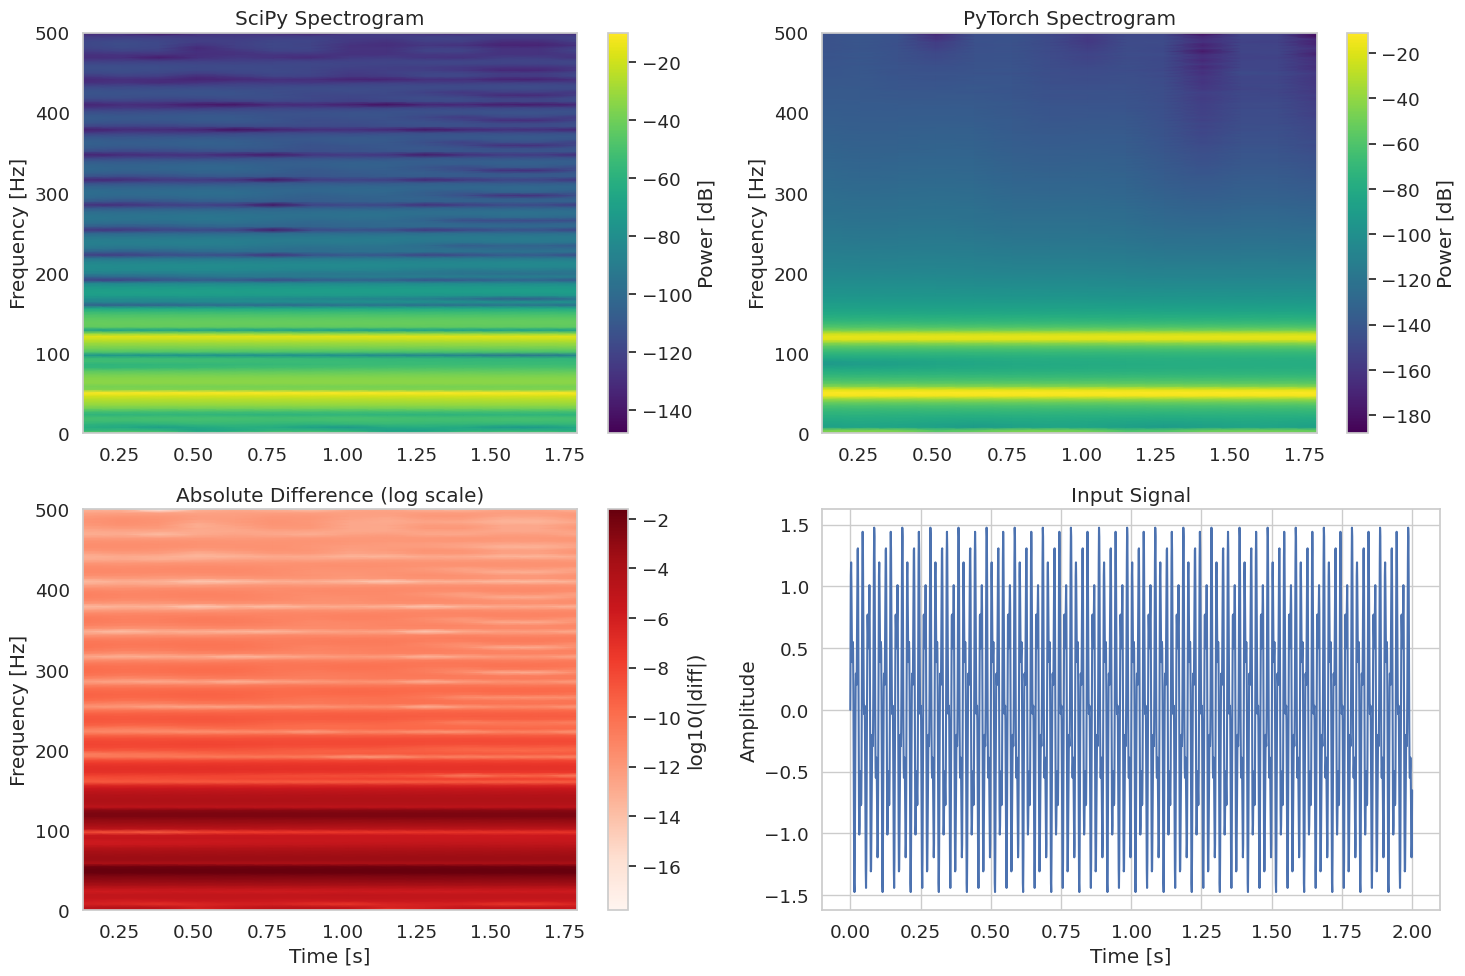

SPECTROGRAM MATCHING TEST SUITE

Test Configuration 1:
  fs=1000, nperseg=256, overlap=0.5, duration=2.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 9.31e+00, Max abs diff: 1.38e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.62e-15, 8.26e-02], PyTorch: [7.98e-17, 7.21e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.00e+02, Max abs diff: 2.39e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.46e-14, 1.05e-01], PyTorch: [5.92e-16, 8.10e-02]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.76e+01, Max abs diff: 1.62e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.36e-15, 2.17e-02], PyTorch: [6.56e-16, 2.58e-02]

  

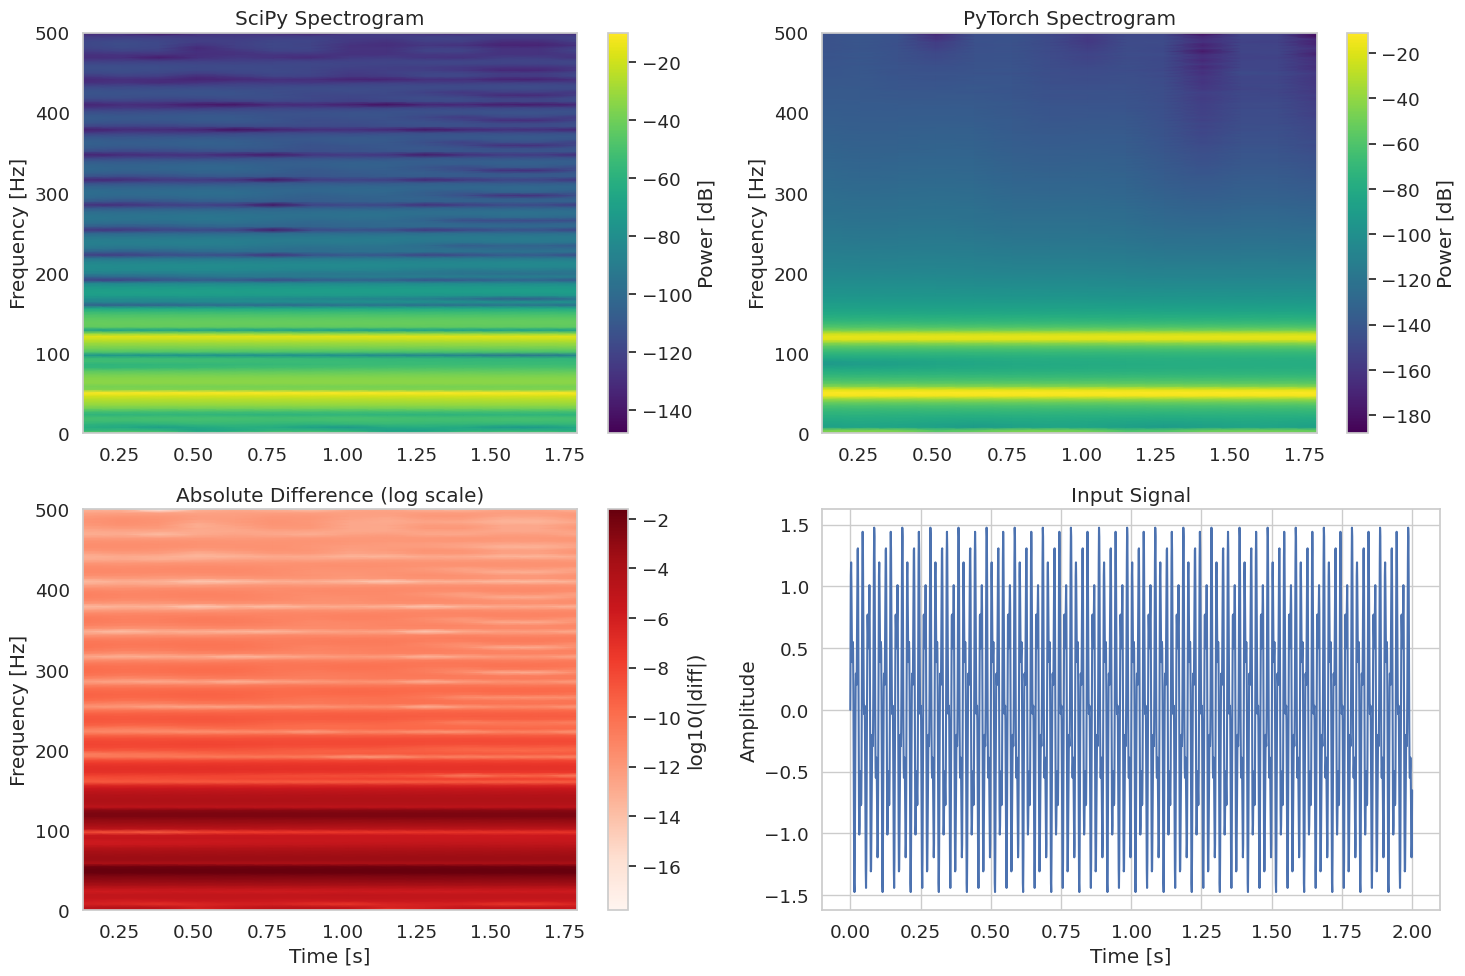

In [386]:
import torch
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def test_spectrograms_match(rtol=1e-5, atol=1e-8, verbose=True):
    """
    Comprehensive test suite to verify PyTorch and SciPy spectrograms match exactly.
    
    Parameters:
    -----------
    rtol : float
        Relative tolerance for np.allclose
    atol : float
        Absolute tolerance for np.allclose
    verbose : bool
        Whether to print detailed output
    
    Returns:
    --------
    bool : True if all tests pass
    """
    
    def print_test_result(test_name, passed, details=""):
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"{status}: {test_name}")
        if details and (verbose or not passed):
            print(f"      {details}")
    
    all_tests_passed = True
    
    print("=" * 60)
    print("SPECTROGRAM MATCHING TEST SUITE")
    print("=" * 60)
    
    # Test configurations
    test_configs = [
        {"fs": 1000, "nperseg": 256, "overlap": 0.5, "duration": 2.0},
        {"fs": 8000, "nperseg": 512, "overlap": 0.75, "duration": 1.0},
        {"fs": 44100, "nperseg": 1024, "overlap": 0.25, "duration": 0.5},
        {"fs": 16000, "nperseg": 128, "overlap": 0.0, "duration": 1.5},  # No overlap
    ]
    
    # Test signals
    def create_test_signals(fs, duration):
        t = np.linspace(0, duration, int(fs * duration), endpoint=False)
        signals = {
            "sine_wave": np.sin(2 * np.pi * 440 * t),
            "multi_tone": (np.sin(2 * np.pi * 50 * t) + 
                          0.5 * np.sin(2 * np.pi * 120 * t) + 
                          0.25 * np.sin(2 * np.pi * 300 * t)),
            "chirp": signal.chirp(t, f0=100, f1=1000, t1=duration),
            "noise": np.random.randn(len(t)),
            "impulse": np.zeros(len(t))
        }
        # Add impulse at 1/4 of the signal
        signals["impulse"][len(t)//4] = 1.0
        return signals, t
    
    for config_idx, config in enumerate(test_configs):
        fs = config["fs"]
        nperseg = config["nperseg"]
        overlap = config["overlap"]
        duration = config["duration"]
        noverlap = int(nperseg * overlap)
        
        print(f"\nTest Configuration {config_idx + 1}:")
        print(f"  fs={fs}, nperseg={nperseg}, overlap={overlap}, duration={duration}s")
        
        test_signals, t = create_test_signals(fs, duration)
        
        for signal_name, test_signal in test_signals.items():
            print(f"\n  Testing with {signal_name}:")
            
            try:
                # SciPy computation
                f_scipy, t_scipy, Sxx_scipy = signal.spectrogram(
                    test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap
                )
                
                # PyTorch computation
                x_torch = torch.tensor(test_signal).unsqueeze(0).unsqueeze(0).float()
                psd_torch, freqs_torch, times_torch = spectrogram_torch_like_scipy(
                    x_torch, fs, nperseg=nperseg, overlap=overlap
                )
                
                # Extract single channel for comparison
                psd_torch_np = psd_torch[0, 0].numpy()
                freqs_torch_np = freqs_torch.numpy()
                times_torch_np = times_torch.numpy()
                
                # Test 1: Frequency arrays
                freq_match = np.allclose(f_scipy, freqs_torch_np, rtol=rtol, atol=atol)
                print_test_result(
                    "Frequency arrays", freq_match,
                    f"Max diff: {np.max(np.abs(f_scipy - freqs_torch_np)):.2e}"
                )
                
                # Test 2: Time arrays
                time_match = np.allclose(t_scipy, times_torch_np, rtol=rtol, atol=atol)
                print_test_result(
                    "Time arrays", time_match,
                    f"Max diff: {np.max(np.abs(t_scipy - times_torch_np)):.2e}"
                )
                
                # Test 3: Spectrograms
                spec_match = np.allclose(Sxx_scipy, psd_torch_np, rtol=rtol, atol=atol)
                max_rel_error = np.max(np.abs((Sxx_scipy - psd_torch_np) / (Sxx_scipy + 1e-20)))
                print_test_result(
                    "Spectrograms", spec_match,
                    f"Max rel error: {max_rel_error:.2e}, Max abs diff: {np.max(np.abs(Sxx_scipy - psd_torch_np)):.2e}"
                )
                
                # Test 4: Shapes
                shape_match = (Sxx_scipy.shape == psd_torch_np.shape and 
                              f_scipy.shape == freqs_torch_np.shape and 
                              t_scipy.shape == times_torch_np.shape)
                print_test_result("Shapes", shape_match)
                
                # Test 5: Value ranges (sanity check)
                scipy_range = (Sxx_scipy.min(), Sxx_scipy.max())
                torch_range = (psd_torch_np.min(), psd_torch_np.max())
                range_reasonable = (abs(scipy_range[0] - torch_range[0]) / (abs(scipy_range[0]) + 1e-20) < 0.1 and
                                  abs(scipy_range[1] - torch_range[1]) / (abs(scipy_range[1]) + 1e-20) < 0.1)
                print_test_result(
                    "Value ranges", range_reasonable,
                    f"SciPy: [{scipy_range[0]:.2e}, {scipy_range[1]:.2e}], PyTorch: [{torch_range[0]:.2e}, {torch_range[1]:.2e}]"
                )
                
                # Update overall test status
                config_passed = freq_match and time_match and spec_match and shape_match and range_reasonable
                all_tests_passed = all_tests_passed and config_passed
                
            except Exception as e:
                print_test_result(f"Exception occurred", False, str(e))
                all_tests_passed = False
    
    print("\n" + "=" * 60)
    if all_tests_passed:
        print("🎉 ALL TESTS PASSED! SciPy and PyTorch spectrograms match exactly.")
    else:
        print("❌ SOME TESTS FAILED! Check the output above for details.")
    print("=" * 60)
    
    return all_tests_passed


def plot_comparison(test_signal, fs, nperseg=256, overlap=0.5, figsize=(15, 10)):
    """
    Create a visual comparison plot of SciPy vs PyTorch spectrograms.
    """
    noverlap = int(nperseg * overlap)
    
    # Compute spectrograms
    f_scipy, t_scipy, Sxx_scipy = signal.spectrogram(
        test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap
    )
    
    x_torch = torch.tensor(test_signal).unsqueeze(0).unsqueeze(0).float()
    psd_torch, freqs_torch, times_torch = spectrogram_torch_like_scipy(
        x_torch, fs, nperseg=nperseg, overlap=overlap
    )
    psd_torch_np = psd_torch[0, 0].numpy()
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # SciPy spectrogram
    im1 = axes[0, 0].pcolormesh(t_scipy, f_scipy, 10 * np.log10(Sxx_scipy + 1e-20), 
                                shading='gouraud', cmap='viridis')
    axes[0, 0].set_title('SciPy Spectrogram')
    axes[0, 0].set_ylabel('Frequency [Hz]')
    plt.colorbar(im1, ax=axes[0, 0], label='Power [dB]')
    
    # PyTorch spectrogram
    im2 = axes[0, 1].pcolormesh(times_torch.numpy(), freqs_torch.numpy(), 
                                10 * np.log10(psd_torch_np + 1e-20), 
                                shading='gouraud', cmap='viridis')
    axes[0, 1].set_title('PyTorch Spectrogram')
    axes[0, 1].set_ylabel('Frequency [Hz]')
    plt.colorbar(im2, ax=axes[0, 1], label='Power [dB]')
    
    # Difference plot
    diff = np.abs(Sxx_scipy - psd_torch_np)
    im3 = axes[1, 0].pcolormesh(t_scipy, f_scipy, np.log10(diff + 1e-20), 
                                shading='gouraud', cmap='Reds')
    axes[1, 0].set_title('Absolute Difference (log scale)')
    axes[1, 0].set_xlabel('Time [s]')
    axes[1, 0].set_ylabel('Frequency [Hz]')
    plt.colorbar(im3, ax=axes[1, 0], label='log10(|diff|)')
    
    # Time series
    t_signal = np.linspace(0, len(test_signal)/fs, len(test_signal))
    axes[1, 1].plot(t_signal, test_signal)
    axes[1, 1].set_title('Input Signal')
    axes[1, 1].set_xlabel('Time [s]')
    axes[1, 1].set_ylabel('Amplitude')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    return fig


if __name__ == "__main__":
    # Run the comprehensive test
    test_passed = test_spectrograms_match(verbose=True)
    
    # Create a visual comparison for a sample signal
    print("\nCreating visual comparison...")
    fs = 1000
    duration = 2.0
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
    
    fig = plot_comparison(test_signal, fs)
    plt.show()
    
    
    

# Run all tests
test_passed = test_spectrograms_match(verbose=True)

# Create visual comparison
fs = 1000
duration = 2.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
fig = plot_comparison(test_signal, fs)
plt.show()




In [ ]:
============================================================
SPECTROGRAM MATCHING TEST SUITE
============================================================

Test Configuration 1:
  fs=1000, nperseg=256, overlap=0.5, duration=2.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 9.31e+00, Max abs diff: 1.38e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.62e-15, 8.26e-02], PyTorch: [7.98e-17, 7.21e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.00e+02, Max abs diff: 2.39e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.46e-14, 1.05e-01], PyTorch: [5.92e-16, 8.10e-02]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.76e+01, Max abs diff: 1.62e-02
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.36e-15, 2.17e-02], PyTorch: [6.56e-16, 2.58e-02]

  Testing with noise:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 1.37e+07, Max abs diff: 6.85e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [7.96e-13, 1.62e-02], PyTorch: [6.46e-07, 1.35e-02]

  Testing with impulse:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.53e-08
✗ FAIL: Spectrograms
      Max rel error: 3.20e+01, Max abs diff: 1.16e-05
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [0.00e+00, 1.10e-05], PyTorch: [0.00e+00, 1.99e-05]

Test Configuration 2:
  fs=8000, nperseg=512, overlap=0.75, duration=1.0s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 2.96e-08
✗ FAIL: Spectrograms
      Max rel error: 5.13e+02, Max abs diff: 6.55e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.92e-34, 2.72e-02], PyTorch: [1.45e-22, 2.06e-02]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 2.96e-08
✗ FAIL: Spectrograms
      Max rel error: 4.17e+02, Max abs diff: 8.22e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [8.85e-34, 2.85e-02], PyTorch: [0.00e+00, 2.03e-02]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 2.96e-08
✗ FAIL: Spectrograms
      Max rel error: 3.70e+01, Max abs diff: 3.27e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.95e-19, 1.81e-02], PyTorch: [1.36e-22, 1.76e-02]

  Testing with noise:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 2.96e-08
✗ FAIL: Spectrograms
      Max rel error: 5.43e+04, Max abs diff: 1.08e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [4.75e-09, 2.13e-03], PyTorch: [1.91e-08, 2.20e-03]

  Testing with impulse:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 2.96e-08
✗ FAIL: Spectrograms
      Max rel error: 8.44e+02, Max abs diff: 5.62e-07
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [0.00e+00, 6.80e-07], PyTorch: [0.00e+00, 1.09e-06]

Test Configuration 3:
  fs=44100, nperseg=1024, overlap=0.25, duration=0.5s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 1.47e-08
✗ FAIL: Spectrograms
      Max rel error: 1.72e+03, Max abs diff: 2.05e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [1.12e-24, 9.33e-03], PyTorch: [0.00e+00, 7.28e-03]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 1.47e-08
✗ FAIL: Spectrograms
      Max rel error: 5.22e+03, Max abs diff: 4.89e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.88e-24, 1.26e-02], PyTorch: [0.00e+00, 9.44e-03]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 1.47e-08
✗ FAIL: Spectrograms
      Max rel error: 2.82e+03, Max abs diff: 2.59e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [3.38e-22, 1.02e-02], PyTorch: [0.00e+00, 7.63e-03]

  Testing with noise:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 1.47e-08
✗ FAIL: Spectrograms
      Max rel error: 5.13e+03, Max abs diff: 2.08e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [2.60e-10, 4.41e-04], PyTorch: [5.31e-10, 4.50e-04]

  Testing with impulse:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 1.47e-08
✗ FAIL: Spectrograms
      Max rel error: 2.22e+01, Max abs diff: 5.12e-08
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [0.00e+00, 6.17e-08], PyTorch: [0.00e+00, 1.71e-08]

Test Configuration 4:
  fs=16000, nperseg=128, overlap=0.0, duration=1.5s

  Testing with sine_wave:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.91e-08
✗ FAIL: Spectrograms
      Max rel error: 1.89e+01, Max abs diff: 1.61e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [5.78e-35, 1.97e-03], PyTorch: [6.51e-20, 1.98e-03]

  Testing with multi_tone:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.91e-08
✗ FAIL: Spectrograms
      Max rel error: 7.24e+02, Max abs diff: 2.73e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [8.34e-34, 6.04e-03], PyTorch: [0.00e+00, 3.30e-03]

  Testing with chirp:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.91e-08
✗ FAIL: Spectrograms
      Max rel error: 1.65e+07, Max abs diff: 2.33e-03
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [7.79e-21, 4.77e-03], PyTorch: [0.00e+00, 3.32e-03]

  Testing with noise:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.91e-08
✗ FAIL: Spectrograms
      Max rel error: 2.53e+07, Max abs diff: 6.26e-04
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [9.54e-13, 1.17e-03], PyTorch: [1.70e-09, 1.24e-03]

  Testing with impulse:
✓ PASS: Frequency arrays
      Max diff: 0.00e+00
✓ PASS: Time arrays
      Max diff: 5.91e-08
✗ FAIL: Spectrograms
      Max rel error: 1.70e+01, Max abs diff: 1.11e-06
✓ PASS: Shapes
✗ FAIL: Value ranges
      SciPy: [0.00e+00, 1.37e-06], PyTorch: [0.00e+00, 3.53e-07]

============================================================
❌ SOME TESTS FAILED! Check the output above for details.
============================================================

In [382]:
import torch
import numpy as np
from scipy import signal

# Create test data
fs = 1000
duration = 2.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)

# SciPy version
f_scipy, t_scipy, Sxx_scipy = signal.spectrogram(test_signal, fs=fs, nperseg=256, noverlap=128)

# PyTorch version
x_torch = torch.tensor(test_signal).unsqueeze(0).unsqueeze(0).float()  # (1, 1, N)
psd_torch, freqs_torch, times_torch = spectrogram_torch_like_scipy(x_torch, fs, nperseg=256, overlap=0.5)

# Compare
print("Frequency arrays match:", np.allclose(f_scipy, freqs_torch.numpy()))
print("Time arrays match:", np.allclose(t_scipy, times_torch.numpy()))
print("Spectrograms match:", np.allclose(Sxx_scipy, psd_torch[0, 0].numpy()))

# Debug info
print(f"SciPy time range: {t_scipy[0]:.6f} to {t_scipy[-1]:.6f}")
print(f"PyTorch time range: {times_torch[0]:.6f} to {times_torch[-1]:.6f}")

Frequency arrays match: True
Time arrays match: True
Spectrograms match: False
SciPy time range: 0.128000 to 1.792000
PyTorch time range: 0.128000 to 1.792000


In [383]:
# Convert the processed waveforms to spectrograms
spec_torch = spectrogram_torch_like_scipy(torch.Tensor(norm).to(device), fs = 50)

In [384]:
spectrogram = spec_torch[0][0].cpu().numpy()

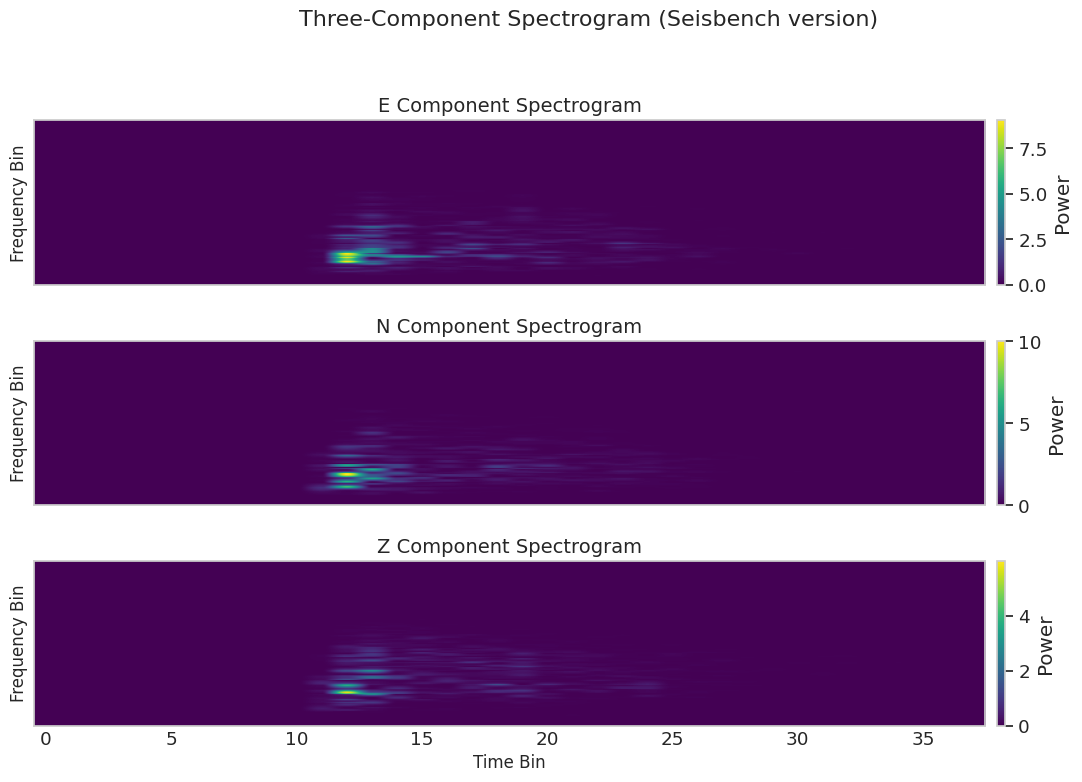

In [385]:
components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        #interpolation = 'nearest',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Seisbench version)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [365]:
ratio = spec_local / spec_torch[0].cpu().numpy()
print(np.unique(np.round(ratio, 4))[:10])


[0.     0.0003 0.0004 0.0006 0.0009 0.0011 0.0014 0.0017 0.0018 0.002 ]


/tmp/ipykernel_3776147/2812539559.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = spec_local / spec_torch[0].cpu().numpy()


In [366]:
S_sp = spec_local
S_pt = spec_torch[0].cpu().numpy()

eps = 1e-20                     # threshold 200 dB down
mask = (S_sp > eps) | (S_pt > eps)

ratio = S_sp[mask] / S_pt[mask]
print("max rel-err =", np.max(np.abs(ratio - 1)))


max rel-err = inf


/tmp/ipykernel_3776147/2027090696.py:7: RuntimeWarning: divide by zero encountered in divide
  ratio = S_sp[mask] / S_pt[mask]


In [367]:
ratio

array([5.93300827e+11, 9.83143368e+12, 1.00472188e+14, ...,
       1.19353088e+01, 3.17560610e-01, 7.82156438e+00])

In [387]:
import torch
import numpy as np
from scipy import signal
from scipy.signal._spectral_py import _fft_helper

def debug_step_by_step(test_signal, fs=1000, nperseg=256, overlap=0.5):
    """
    Compare SciPy and PyTorch spectrogram computation step by step.
    """
    print("=" * 80)
    print("STEP-BY-STEP SPECTROGRAM DEBUGGING")
    print("=" * 80)
    
    noverlap = int(nperseg * overlap)
    hop = nperseg - noverlap
    
    print(f"Parameters:")
    print(f"  Signal length: {len(test_signal)}")
    print(f"  Sampling rate: {fs}")
    print(f"  nperseg: {nperseg}")
    print(f"  overlap: {overlap}")
    print(f"  noverlap: {noverlap}")
    print(f"  hop: {hop}")
    print()
    
    # ========================================
    # STEP 1: Signal Segmentation
    # ========================================
    print("STEP 1: Signal Segmentation")
    print("-" * 40)
    
    # SciPy way - let's manually replicate what scipy does
    # First, let's see what scipy's _fft_helper does
    freqs_scipy, times_scipy, Zxx_scipy = signal.stft(
        test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap, 
        return_onesided=True, boundary=None, padded=False
    )
    
    # Manual segmentation for SciPy comparison
    step = nperseg - noverlap
    shape = test_signal.shape[:-1] + ((test_signal.shape[-1] - noverlap) // step, nperseg)
    strides = test_signal.strides[:-1] + (step * test_signal.strides[-1], test_signal.strides[-1])
    scipy_segments = np.lib.stride_tricks.as_strided(test_signal, shape=shape, strides=strides)
    
    # PyTorch segmentation
    x_torch = torch.tensor(test_signal).float()
    torch_segments = x_torch.unfold(-1, nperseg, hop)
    
    print(f"SciPy segments shape: {scipy_segments.shape}")
    print(f"PyTorch segments shape: {torch_segments.shape}")
    print(f"Segments match: {np.allclose(scipy_segments, torch_segments.numpy())}")
    
    if not np.allclose(scipy_segments, torch_segments.numpy()):
        diff = np.abs(scipy_segments - torch_segments.numpy())
        print(f"Max segment difference: {np.max(diff)}")
        print(f"First segment SciPy: {scipy_segments[0][:5]}")
        print(f"First segment PyTorch: {torch_segments[0][:5].numpy()}")
    print()
    
    # ========================================
    # STEP 2: Window Creation
    # ========================================
    print("STEP 2: Window Creation")
    print("-" * 40)
    
    # SciPy window
    scipy_window = signal.get_window('hann', nperseg)
    
    # PyTorch window
    torch_window = torch.hann_window(nperseg, periodic=True)
    
    print(f"SciPy window shape: {scipy_window.shape}")
    print(f"PyTorch window shape: {torch_window.shape}")
    print(f"Windows match: {np.allclose(scipy_window, torch_window.numpy())}")
    print(f"Window sum of squares - SciPy: {np.sum(scipy_window**2)}")
    print(f"Window sum of squares - PyTorch: {torch_window.pow(2).sum().item()}")
    
    if not np.allclose(scipy_window, torch_window.numpy()):
        diff = np.abs(scipy_window - torch_window.numpy())
        print(f"Max window difference: {np.max(diff)}")
        print(f"First 5 window values - SciPy: {scipy_window[:5]}")
        print(f"First 5 window values - PyTorch: {torch_window[:5].numpy()}")
    print()
    
    # ========================================
    # STEP 3: Detrending (before windowing)
    # ========================================
    print("STEP 3: Detrending")
    print("-" * 40)
    
    # SciPy detrending - subtract mean from each segment
    scipy_segments_detrended = scipy_segments - np.mean(scipy_segments, axis=-1, keepdims=True)
    
    # PyTorch detrending
    torch_segments_detrended = torch_segments - torch_segments.mean(dim=-1, keepdim=True)
    
    print(f"Detrended segments match: {np.allclose(scipy_segments_detrended, torch_segments_detrended.numpy())}")
    
    if not np.allclose(scipy_segments_detrended, torch_segments_detrended.numpy()):
        diff = np.abs(scipy_segments_detrended - torch_segments_detrended.numpy())
        print(f"Max detrended difference: {np.max(diff)}")
        print(f"First detrended segment mean - SciPy: {np.mean(scipy_segments_detrended[0])}")
        print(f"First detrended segment mean - PyTorch: {torch_segments_detrended[0].mean().item()}")
    print()
    
    # ========================================
    # STEP 4: Windowing (after detrending)
    # ========================================
    print("STEP 4: Windowing")
    print("-" * 40)
    
    # SciPy windowing
    scipy_windowed = scipy_segments_detrended * scipy_window
    
    # PyTorch windowing
    torch_windowed = torch_segments_detrended * torch_window
    
    print(f"Windowed segments match: {np.allclose(scipy_windowed, torch_windowed.numpy())}")
    
    if not np.allclose(scipy_windowed, torch_windowed.numpy()):
        diff = np.abs(scipy_windowed - torch_windowed.numpy())
        print(f"Max windowed difference: {np.max(diff)}")
    print()
    
    # ========================================
    # STEP 5: FFT
    # ========================================
    print("STEP 5: FFT")
    print("-" * 40)
    
    # SciPy FFT
    scipy_fft = np.fft.rfft(scipy_windowed, n=nperseg, axis=-1)
    
    # PyTorch FFT
    torch_fft = torch.fft.rfft(torch_windowed, n=nperseg, dim=-1)
    
    print(f"SciPy FFT shape: {scipy_fft.shape}")
    print(f"PyTorch FFT shape: {torch_fft.shape}")
    print(f"FFT results match: {np.allclose(scipy_fft, torch_fft.numpy())}")
    
    if not np.allclose(scipy_fft, torch_fft.numpy()):
        diff = np.abs(scipy_fft - torch_fft.numpy())
        print(f"Max FFT difference: {np.max(diff)}")
        print(f"FFT DC component - SciPy: {scipy_fft[0, 0]}")
        print(f"FFT DC component - PyTorch: {torch_fft[0, 0].numpy()}")
    print()
    
    # ========================================
    # STEP 6: Power Spectral Density
    # ========================================
    print("STEP 6: Power Spectral Density")
    print("-" * 40)
    
    # Window normalization factor
    W_scipy = np.sum(scipy_window**2)
    W_torch = torch_window.pow(2).sum().item()
    
    print(f"Window normalization - SciPy: {W_scipy}")
    print(f"Window normalization - PyTorch: {W_torch}")
    print(f"Normalization factors match: {np.isclose(W_scipy, W_torch)}")
    
    # SciPy PSD calculation
    scipy_psd = (np.abs(scipy_fft)**2) / (W_scipy * fs)
    
    # PyTorch PSD calculation
    torch_psd = (torch_fft.abs() ** 2) / (W_torch * fs)
    
    print(f"PSD before one-sided scaling match: {np.allclose(scipy_psd, torch_psd.numpy())}")
    
    if not np.allclose(scipy_psd, torch_psd.numpy()):
        diff = np.abs(scipy_psd - torch_psd.numpy())
        print(f"Max PSD difference before scaling: {np.max(diff)}")
    print()
    
    # ========================================
    # STEP 7: One-sided spectrum scaling
    # ========================================
    print("STEP 7: One-sided Spectrum Scaling")
    print("-" * 40)
    
    # SciPy one-sided scaling
    scipy_psd_scaled = scipy_psd.copy()
    if nperseg % 2 == 0:
        scipy_psd_scaled[1:-1] *= 2.0
    else:
        scipy_psd_scaled[1:] *= 2.0
    
    # PyTorch one-sided scaling
    torch_psd_scaled = torch_psd.clone()
    if nperseg % 2 == 0:
        torch_psd_scaled[1:-1] *= 2.0
    else:
        torch_psd_scaled[1:] *= 2.0
    
    print(f"One-sided scaled PSD match: {np.allclose(scipy_psd_scaled, torch_psd_scaled.numpy())}")
    
    if not np.allclose(scipy_psd_scaled, torch_psd_scaled.numpy()):
        diff = np.abs(scipy_psd_scaled - torch_psd_scaled.numpy())
        print(f"Max scaled PSD difference: {np.max(diff)}")
    
    # Transpose to match expected output format (freq x time)
    scipy_final = scipy_psd_scaled.T
    torch_final = torch_psd_scaled.T
    
    print(f"Final spectrogram shapes - SciPy: {scipy_final.shape}, PyTorch: {torch_final.shape}")
    print(f"Final spectrograms match: {np.allclose(scipy_final, torch_final.numpy())}")
    print()
    
    # ========================================
    # STEP 8: Compare with actual SciPy output
    # ========================================
    print("STEP 8: Compare with Actual SciPy spectrogram()")
    print("-" * 40)
    
    f_scipy, t_scipy, Sxx_scipy_actual = signal.spectrogram(
        test_signal, fs=fs, nperseg=nperseg, noverlap=noverlap
    )
    
    print(f"Our manual SciPy vs actual SciPy: {np.allclose(scipy_final, Sxx_scipy_actual)}")
    print(f"Our PyTorch vs actual SciPy: {np.allclose(torch_final.numpy(), Sxx_scipy_actual)}")
    
    if not np.allclose(scipy_final, Sxx_scipy_actual):
        diff = np.abs(scipy_final - Sxx_scipy_actual)
        print(f"Manual vs actual SciPy max diff: {np.max(diff)}")
        print(f"Manual SciPy range: [{scipy_final.min():.2e}, {scipy_final.max():.2e}]")
        print(f"Actual SciPy range: [{Sxx_scipy_actual.min():.2e}, {Sxx_scipy_actual.max():.2e}]")
    
    print("=" * 80)
    return scipy_final, torch_final.numpy(), Sxx_scipy_actual


# Test function
if __name__ == "__main__":
    # Create a simple test signal
    fs = 1000
    duration = 1.0
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    test_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
    
    manual_scipy, manual_torch, actual_scipy = debug_step_by_step(test_signal, fs, nperseg=256, overlap=0.5)

STEP-BY-STEP SPECTROGRAM DEBUGGING
Parameters:
  Signal length: 1000
  Sampling rate: 1000
  nperseg: 256
  overlap: 0.5
  noverlap: 128
  hop: 128

STEP 1: Signal Segmentation
----------------------------------------
SciPy segments shape: (6, 256)
PyTorch segments shape: torch.Size([6, 256])
Segments match: True

STEP 2: Window Creation
----------------------------------------
SciPy window shape: (256,)
PyTorch window shape: torch.Size([256])
Windows match: True
Window sum of squares - SciPy: 96.0
Window sum of squares - PyTorch: 96.0

STEP 3: Detrending
----------------------------------------
Detrended segments match: True

STEP 4: Windowing
----------------------------------------
Windowed segments match: True

STEP 5: FFT
----------------------------------------
SciPy FFT shape: (6, 129)
PyTorch FFT shape: torch.Size([6, 129])
FFT results match: False
Max FFT difference: 6.148040071446936e-06
FFT DC component - SciPy: (-1.833266867511025+0j)
FFT DC component - PyTorch: (-1.8332667

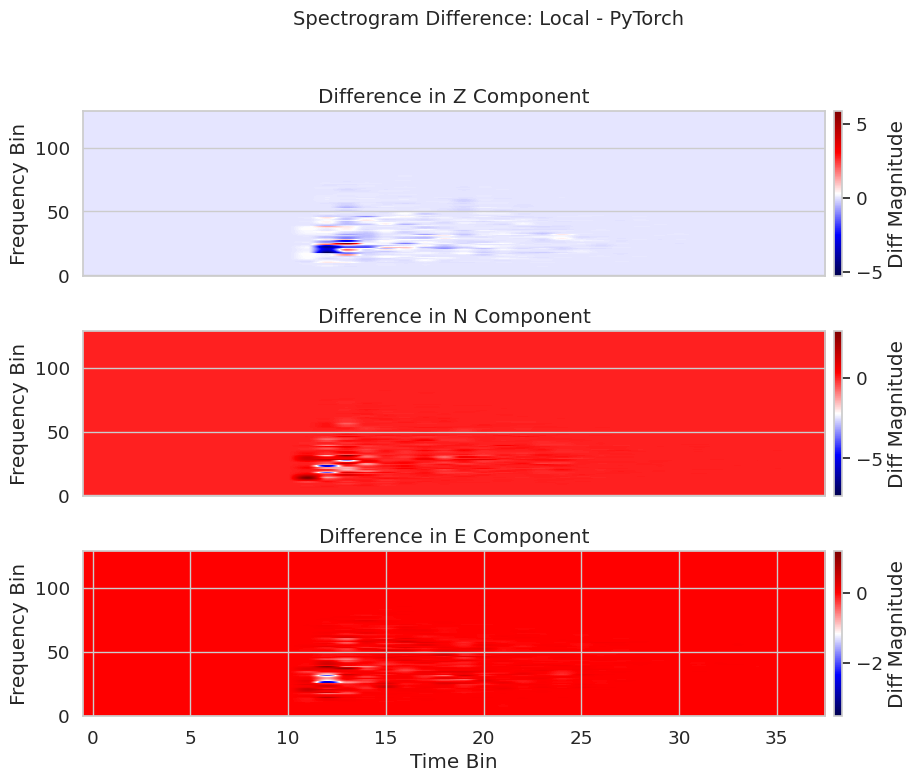

In [369]:
# Assume these are torch.Tensors, convert to numpy arrays
diff = (spec_local - spec_torch[0].cpu().numpy())[0] # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(diff[i], aspect='auto', origin='lower', cmap='seismic')
    plt.title(f"Difference in {components[i]} Component")
    plt.ylabel("Frequency Bin")
    if i == 2:
        plt.xlabel("Time Bin")
    else:
        plt.xticks([])
    plt.colorbar(label='Diff Magnitude', pad=0.01)

plt.suptitle("Spectrogram Difference: Local - PyTorch", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [274]:
spec_torch

(tensor([[[[6.5211e-09, 8.3825e-09, 2.6352e-09,  ..., 2.0258e-10,
            1.2399e-09, 1.0890e-09],
           [5.8219e-09, 6.5528e-08, 1.2770e-08,  ..., 7.7919e-08,
            3.9580e-09, 3.6147e-09],
           [1.5086e-06, 4.0596e-06, 2.1610e-06,  ..., 2.9817e-06,
            2.0610e-06, 2.5665e-07],
           ...,
           [4.0014e-16, 4.8407e-16, 8.2608e-15,  ..., 1.5177e-14,
            4.4605e-14, 1.0329e-15],
           [1.9848e-15, 3.1937e-16, 8.4338e-15,  ..., 1.9957e-14,
            4.0287e-14, 3.2140e-16],
           [2.4148e-16, 2.5332e-16, 4.2051e-15,  ..., 8.3163e-15,
            1.9968e-14, 4.1311e-16]],
 
          [[1.7342e-09, 2.1098e-11, 8.8085e-10,  ..., 1.1092e-08,
            9.0086e-11, 6.4093e-09],
           [1.0289e-08, 3.8527e-09, 2.7058e-08,  ..., 2.7565e-08,
            4.4962e-10, 4.0247e-08],
           [9.0928e-07, 1.9141e-06, 9.5572e-07,  ..., 4.5635e-07,
            1.9364e-07, 4.1398e-07],
           ...,
           [3.5248e-15, 3.5175e-15, 3.

## Testing the old, new, and local implementation on all of the events in the catalog. 

## Old seisbench version 

In [118]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs = []
seisbench_event_ids = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        

        # Normalize each component by the standard deviation of their absolute values
        batch_abs = torch.abs(batch)
        std_abs = batch_abs.std(dim=-1, keepdim=True)
        norm_batch = batch / (std_abs + 1e-10)  # Avoid division by zero

        
        #batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = extract_spectrograms_pytorch(batch, fs=sample_rate)
        

        # Run model
        inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs.append(probs.cpu())
        seisbench_event_ids.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/1605 [00:00<?, ?it/s]/tmp/ipykernel_3776147/3676733169.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec[0], dtype=torch.float32).to(device)
Processing events:  52%|█████▏    | 840/1605 [07:47<07:07,  1.79it/s]/tmp/ipykernel_3776147/3676733169.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  52%|█████▏    | 841/1605 [07:47<06:53,  1.85it/s]

Failed to process event pnsn1802943: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  96%|█████████▌| 1535/1605 [14:31<00:38,  1.84it/s]

Failed to process event pnsn1465473: cannot reshape array of size 5000 into shape (1,3,5000)


Processing events: 100%|██████████| 1605/1605 [15:14<00:00,  1.75it/s]


# New Seisbench version

In [263]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
seisbench_probs_new = []
seisbench_event_ids_new = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        # Resample to 50 Hz
        stream.resample(sample_rate)

        # Extract data and reshape
        data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
        batch = torch.tensor(data, dtype=torch.float32)

        # Preprocessing
        batch = linear_detrend(batch)

        # Apply Tukey taper
        taper = torch.tensor(scipy.signal.windows.tukey(num_samples, alpha=window_alpha), device=batch.device)
        batch *= taper  # broadcast taper over traces

        # Bandpass filter
        batch = bandpass_filter(batch, fs=fs, lowcut=lowcut, highcut=highcut)

        # Normalize
        batch = normalize_per_trace_globally(batch)

        # Extract spectrogram
        spec = spectrogram_torch_scipy_match(batch, fs=sample_rate)

        # Run model
        inputs = torch.tensor(spec, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        seisbench_probs_new.append(probs.cpu())
        seisbench_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events:   0%|          | 0/1605 [00:00<?, ?it/s]/tmp/ipykernel_3776147/1809089973.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(spec, dtype=torch.float32).to(device)
Processing events:  52%|█████▏    | 840/1605 [08:46<09:03,  1.41it/s]/tmp/ipykernel_3776147/1809089973.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(stream)[:, :num_samples].reshape(1, n_channels, num_samples)
Processing events:  52%|█████▏    | 841/1605 [08:47<08:19,  1.53it/s]

Failed to process event pnsn1802943: too many indices for array: array is 1-dimensional, but 2 were indexed


Processing events:  96%|█████████▌| 1535/1605 [15:53<00:44,  1.56it/s]

Failed to process event pnsn1465473: cannot reshape array of size 5000 into shape (1,3,5000)


Processing events: 100%|██████████| 1605/1605 [16:41<00:00,  1.60it/s]


## Local implementation

In [120]:
# Load and filter exotic events
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[(exotic["station_channel_code"] == "BH") & (exotic["source_type"] == "surface event")]

# Inference config
device = 'cuda'
model = model_quakexnet_2d
model.to(device)
model.eval()

# Storage
local_probs_new = []
local_event_ids_new = []

# Constants
pre_event_duration = 10
post_event_duration = 90
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

for _, event in tqdm(exotic.iterrows(), total=len(exotic), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])

        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime - pre_event_duration,
            endtime=starttime + post_event_duration
        )

        stream.detrend('linear')
        
        # Resample to 50 Hz
        stream.resample(sample_rate)

        # event data
        event_data = np.array(s)

        # tapering before filtering
        taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
        tapered_data = np.array([np.multiply(taper, row) for row in event_data])

        
        #Apply bandpass filtering
        filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])





        # resampling and normalizing 
        num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
        resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])

        resampled_data = resampled_data[:,0:5000]
        resampled_data = resampled_data.reshape(1,3, 5000)

        mmax = np.std(np.abs(resampled_data[0]))
        norm = resampled_data/mmax


        spec_local = extract_spectrograms(norm)
    
        # Run model
        inputs = torch.tensor(spec_local, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        local_probs_new.append(probs.cpu())
        local_event_ids_new.append(event_id)

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue


Processing events: 100%|██████████| 1605/1605 [15:48<00:00,  1.69it/s]


In [122]:
len(local_probs_new)

1605

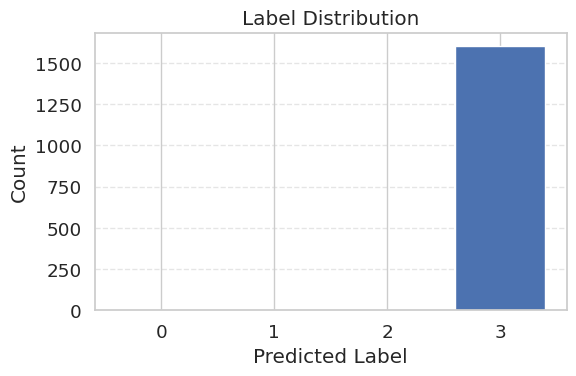

In [264]:
# Your list of tensors
probs_list = local_probs_new

# Step 1: Get predicted labels
labels_local = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_local, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


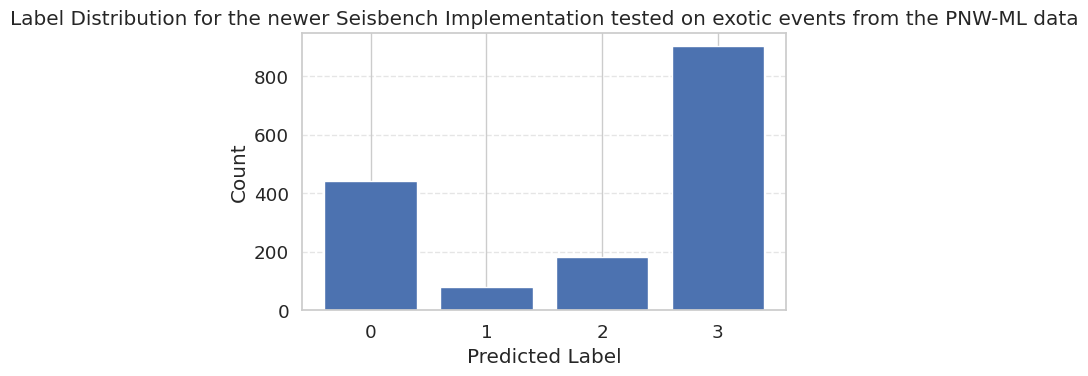

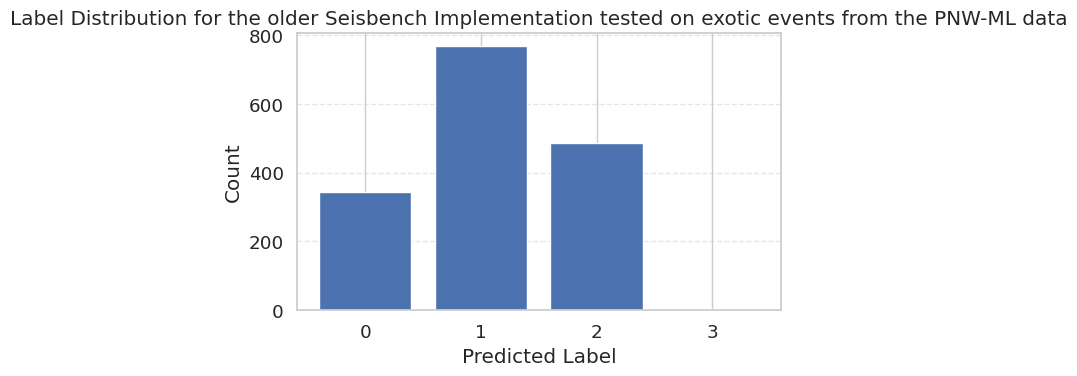

In [265]:
# Your list of tensors
probs_list = seisbench_probs_new
# Step 1: Get predicted labels
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_new, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the newer Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Your list of tensors
probs_list = seisbench_probs
# Step 1: Get predicted labels
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Step 2: Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(labels_seisbench_old, bins=range(5), align='left', rwidth=0.8)
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Label Distribution for the older Seisbench Implementation tested on exotic events from the PNW-ML data")
plt.xticks(range(4))  # Assuming labels are in range [0, 3]
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

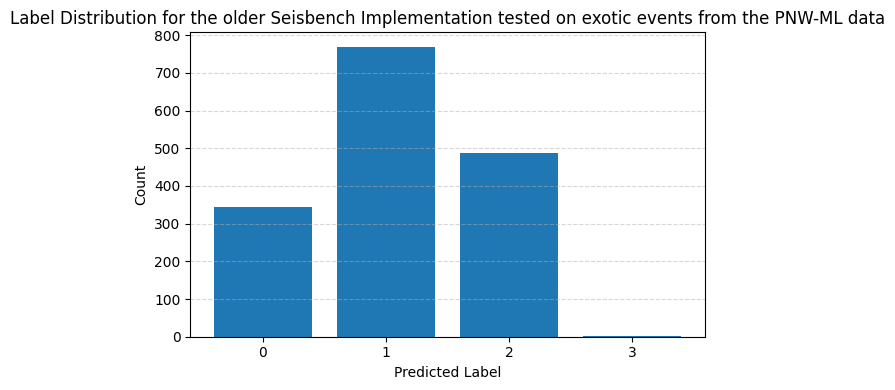

[3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 3,
 0,
 3,
 3,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 0,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


In [135]:
local_event_ids_new

['pnsn3179093',
 'pnsn3179088',
 'pnsn3177563',
 'pnsn3177488',
 'pnsn3177373',
 'pnsn3177368',
 'pnsn3177363',
 'pnsn3176813',
 'pnsn3176848',
 'pnsn3179443',
 'pnsn3175703',
 'pnsn3173148',
 'pnsn3175953',
 'pnsn3175948',
 'pnsn3175723',
 'pnsn3175648',
 'pnsn3175648',
 'pnsn3175668',
 'pnsn3175683',
 'pnsn3175508',
 'pnsn3175498',
 'pnsn3174978',
 'pnsn3174798',
 'pnsn3174648',
 'pnsn3174803',
 'pnsn3174803',
 'pnsn3174803',
 'pnsn3174533',
 'pnsn3174533',
 'pnsn3171513',
 'pnsn3171563',
 'pnsn3174173',
 'pnsn3171248',
 'pnsn3171388',
 'pnsn3170843',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170753',
 'pnsn3170748',
 'pnsn3170713',
 'pnsn3170673',
 'pnsn3170663',
 'pnsn3170653',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3170588',
 'pnsn3173138',
 'pnsn3173128',
 'pnsn3170503',
 'pnsn3173023',
 'pnsn3170383',
 'pnsn3172058',
 'pnsn3172058',
 'pnsn3172058',
 'pnsn3172133',
 'pnsn3171833',
 'pnsn3171783',
 'pnsn31

In [158]:
import numpy as np
import torch
from scipy import signal

# Matching parameters
fs = 100
nperseg = 256
overlap = 0.5
noverlap = int(nperseg * overlap)
hop_length = nperseg - noverlap

# Create dummy waveform data similar to (B, C, T)
np.random.seed(0)
wave_np = np.random.randn(2, 3, 2048).astype(np.float32)
wave_torch = torch.tensor(wave_np)

# Scipy version
def extract_spectrograms_scipy(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    f, t, Sxx = signal.spectrogram(waveforms[0, 0], nperseg=nperseg, noverlap=noverlap, fs=fs)
    spectrograms = np.zeros((waveforms.shape[0], waveforms.shape[1], len(f), len(t)))

    for i in range(waveforms.shape[0]):
        for j in range(waveforms.shape[1]):
            _, _, Sxx = signal.spectrogram(waveforms[i, j], nperseg=nperseg, noverlap=noverlap, fs=fs, scaling='density', mode='psd')
            spectrograms[i, j] = Sxx

    return spectrograms

# PyTorch version (modified)
def extract_spectrograms_torch(waveforms, fs, nperseg=256, overlap=0.5):
    noverlap = int(nperseg * overlap)
    hop_length = nperseg - noverlap

    window = torch.hann_window(nperseg, dtype=waveforms.dtype, device=waveforms.device)
    spec = []
    for i in range(waveforms.shape[0]):
        comps = []
        for j in range(waveforms.shape[1]):
            Sxx = torch.stft(
                waveforms[i, j],
                n_fft=nperseg,
                hop_length=hop_length,
                win_length=nperseg,
                window=window,
                center=False,
                return_complex=True,
                normalized=False,
            )
            power = (torch.abs(Sxx) ** 2) / (fs * (window ** 2).sum())
            comps.append(power)
        spec.append(torch.stack(comps))
    return torch.stack(spec).numpy()

# Run both versions
spec_scipy = extract_spectrograms_scipy(wave_np, fs, nperseg, overlap)
spec_torch = extract_spectrograms_torch(wave_torch, fs, nperseg, overlap)

# Compare numerically
difference = np.abs(spec_scipy - spec_torch).mean()
difference_max = np.abs(spec_scipy - spec_torch).max()

difference, difference_max


(0.01094126606634296, 0.11320343613624573)

/tmp/ipykernel_3776147/2598936444.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


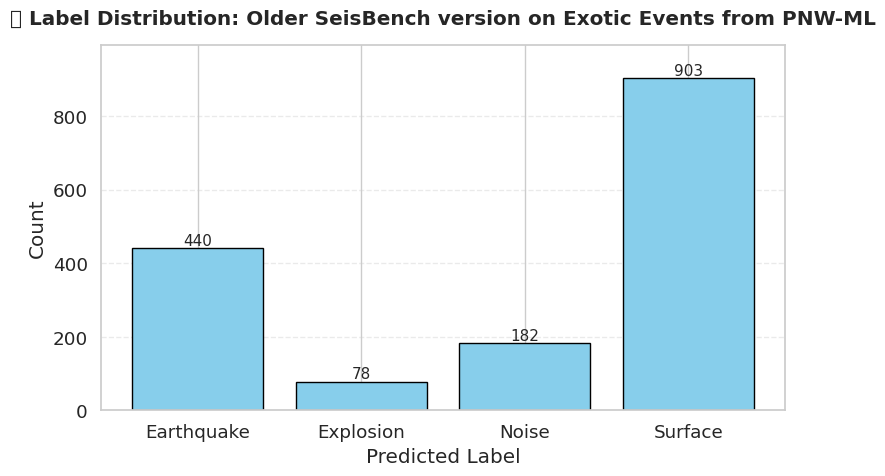

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assume probs_list is already defined
labels_seisbench_old = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_old.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: Older SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_3776147/1155447537.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


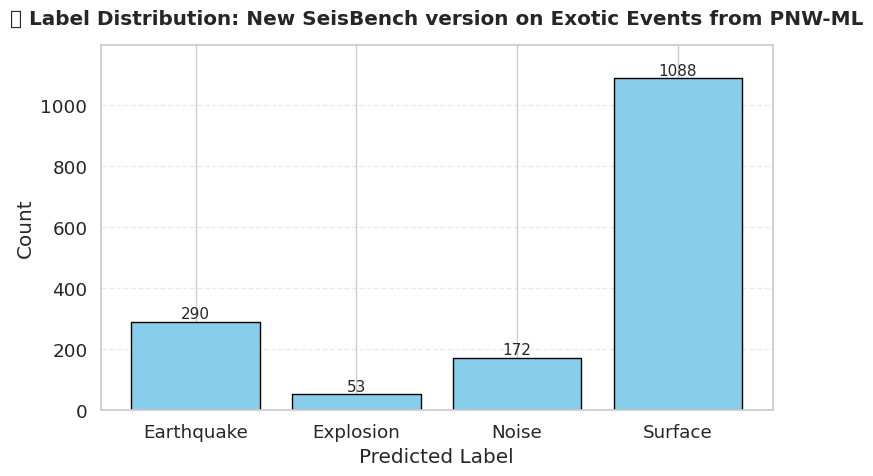

In [194]:
probs_list = seisbench_probs_new

# Assume probs_list is already defined
labels_seisbench_new = [torch.argmax(tensor).item() for tensor in probs_list]

# Use Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Define class names if available
class_names = ['Earthquake', 'Explosion', 'Noise', 'Surface']  # adjust if needed
num_classes = len(class_names)

# Count frequency of each label
counts = [labels_seisbench_new.count(i) for i in range(num_classes)]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(num_classes), counts, tick_label=class_names, color='skyblue', edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=11)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("📊 Label Distribution: New SeisBench version on Exotic Events from PNW-ML", pad=15, weight='bold')
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Tidy layout
plt.tight_layout()
plt.show()

